In [50]:
from aerobot.dataset import dataset_load_all
from aerobot.plot import *
# from aerobot.utils import print_taxonomy_info
from aerobot.io import FEATURE_SUBTYPES, FEATURE_TYPES, load_results_dict, RESULTS_PATH
import numpy as np 
import os
from aerobot.models import MeanRelative, GeneralClassifier
import pandas as pd 
import subprocess
from typing import Dict

%load_ext autoreload
%autoreload 2

plt.rcParams['image.cmap'] = 'Blues'
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.Blues(np.linspace(0.2, 1, 6)[::-1]))
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial']})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# RESULTS_PATH = os.path.join(RESULTS_PATH, 'phylo_bias')
EMB_PATH = os.path.join(RESULTS_PATH, 'earth_microbiome')
PB_PATH = os.path.join(RESULTS_PATH, 'phylo_bias')
LEVELS = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
# feature_types = ['KO', 'embedding.geneset.oxygen', 'chemical', 'aa_1mer', 'aa_3mer']  # Minimal list of feature types.

In [52]:
# Load in the genome metadata, which includes taxonomy. For whatever reason, the taxonomy string is under the "ecosystem" column. 
metadata_df = pd.read_csv(os.path.join(EMB_PATH, 'emb_metadata.tsv'), delimiter='\t')

In [53]:
metadata_df.head()

,genome_id,metagenome_id,genome_length,num_contigs,n50,num_16s,num_5s,num_23s,num_trna,completeness,contamination,quality_score,mimag_quality,otu_id,ecosystem,ecosystem_category,ecosystem_type,habitat,longitude,latitude
0,3300025516_6,3300025516,2910752,137,34707,1.0,1.0,1.0,43.0,90.42,0.65,87.17,HQ,OTU-1761,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,Terrestrial,Deep subsurface,Serpentinite rock and fluid,-122.439,38.874
1,3300025516_8,3300025516,2473071,426,6047,1.0,0.0,0.0,37.0,65.97,2.52,53.37,MQ,OTU-11015,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Terrestrial,Deep subsurface,Serpentinite rock and fluid,-122.439,38.874
2,3300025516_7,3300025516,2626327,104,45304,1.0,1.0,0.0,48.0,94.49,1.13,88.84,MQ,OTU-1762,d__Bacteria;p__Firmicutes_D;c__UBA994;o__UBA99...,Terrestrial,Deep subsurface,Serpentinite rock and fluid,-122.439,38.874
3,3300025516_3,3300025516,3300395,411,9060,0.0,0.0,0.0,31.0,79.36,4.74,55.66,MQ,OTU-8708,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,Terrestrial,Deep subsurface,Serpentinite rock and fluid,-122.439,38.874
4,3300025516_1,3300025516,4906168,289,24717,1.0,1.0,1.0,47.0,94.19,3.23,78.04,HQ,OTU-17789,d__Bacteria;p__Desulfobacterota;c__BSN033;o__B...,Terrestrial,Deep subsurface,Serpentinite rock and fluid,-122.439,38.874


In [54]:
def parse_taxonomy(taxonomy_string:str) -> Dict[str, str]:
    '''Parse a taxonomy string into a dictionary mapping the taxonomic level to the organism's taxonomy.'''
    prefix_map = {'d':'Domain', 'p':'Phylum', 'c':'Class', 'o':'Order', 'f':'Family', 'g':'Genus', 's':'Species'}
    # Sometimes the entry is NaN, which I am taking to mean no taxonomic label. 
    if type(taxonomy_string) != str:
        return dict()

    taxonomy = taxonomy_string.split(';')
    taxonomy = [tuple(t.split('__')) for t in taxonomy]
    taxonomy = {prefix_map[p]:t for p, t in taxonomy}
    return taxonomy

taxonomy_df = []
for metadata_row in metadata_df.itertuples():
    row = dict()
    row['genome_id'] = metadata_row.genome_id
    row['habitat'] = metadata_row.habitat
    row.update(parse_taxonomy(metadata_row.ecosystem))
    taxonomy_df.append(row)
taxonomy_df = pd.DataFrame(taxonomy_df)
taxonomy_df = taxonomy_df.fillna('') # Fill any remaining NaNs with empty strings. 

In [55]:
for level in ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']:
    coverage = taxonomy_df[level].apply(len).values
    coverage = np.sum(coverage > 0) / len(coverage)
    print(f'Proportion of genomes with {level} label:', np.round(coverage, 2))

Proportion of genomes with Domain label: 1.0
Proportion of genomes with Phylum label: 1.0
Proportion of genomes with Class label: 1.0
Proportion of genomes with Order label: 0.97
Proportion of genomes with Family label: 0.93
Proportion of genomes with Genus label: 0.76
Proportion of genomes with Species label: 0.44


The goal is to produce a figure which communicates the downsides of using phylogeny labels for metabolic predictions. From the phylogenetic bias analysis using the random- and mean-relative approaches, it seems that phylogeny is a great way to predict metabolic features. However, we often don't have phylogeny labels.

In order to show this, we can (1) group the Earth Microbiome Project data by sample and (2) plot the percentage of each sample which has a phylogeny label at each level. This will account for the variation in coverage between samples; for example, we can probably expect the human microbiome samples to be characterized much more thoroughly. 

In [56]:
# Replace habitat names with more general categories. This is the same map used to generate Figure 2. 
habitat_map = pd.read_csv(os.path.join(EMB_PATH, 'emb_habitats.csv'), index_col=0).to_dict()['habitat']
# Change the human entries in the habitat map to distinguish. 
habitat_map['Human feces'] = 'Human feces'
habitat_map['Human fecal'] = 'Human feces'
habitat_map.pop('Human oral')
habitat_map.pop('Human colon tissue')
habitat_map.pop('Human bile duct')
habitat_map.pop('Premature human infant gut')
habitat_map.pop('Human skin')
habitat_map.pop('Human gut')
taxonomy_df.habitat = taxonomy_df.habitat.replace(habitat_map)

# Some habitats don't seem to be matching up, so try to remove any potential reasons for this. 
taxonomy_df.habitat = taxonomy_df.habitat.str.lower()
taxonomy_df.habitat = taxonomy_df.habitat.str.strip()

In [57]:
def get_coverage(df:pd.DataFrame, level:str):
    '''Get the fraction of organisms with a phylogenetic label at the specified level.'''
    coverage = df[level].apply(len).values
    coverage = np.sum(coverage > 0) / len(coverage)
    return coverage

coverage_by_habitat_df = []

for habitat, df in taxonomy_df.groupby('habitat'):
    row = dict()
    row['habitat'] = habitat
    for level in LEVELS:
        row[level] = get_coverage(df, level)
    coverage_by_habitat_df.append(row)
coverage_by_habitat_df = pd.DataFrame(coverage_by_habitat_df)    

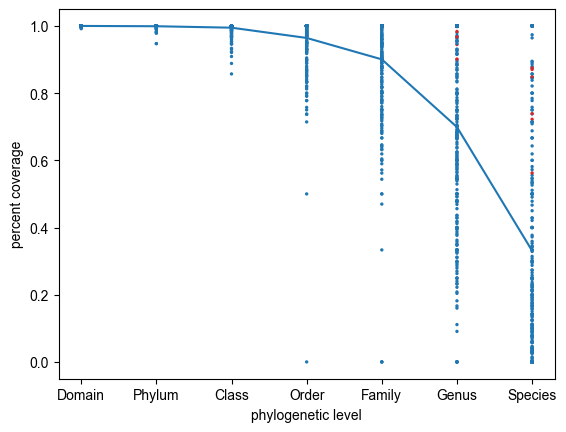

In [58]:
# Make the easiest plot, which just shows percent coverage by phylogenetic level. 
fig, ax = plt.subplots()
n = len(coverage_by_habitat_df) # Number of habitats. 

human_samples = coverage_by_habitat_df.habitat.str.contains('human').values # NOT a full match, so should pick up any habitat with substring "human."
colors = ['tab:blue' if not is_human else 'tab:red' for is_human in human_samples]

for i, level in enumerate(LEVELS):
    ax.scatter(np.array([i] * n), coverage_by_habitat_df[level].values, s=2, color=colors)

x_vals, y_vals = [], []
for i, level in enumerate(LEVELS): # Make sure these are plotted on top.
    x_vals.append(i)
    y_vals.append(coverage_by_habitat_df[level].mean())

ax.plot(x_vals, y_vals, c='tab:blue')

ax.set_xticks(np.arange(len(LEVELS)), labels=LEVELS)
ax.set_ylabel('percent coverage')
ax.set_xlabel('phylogenetic level')
plt.show()

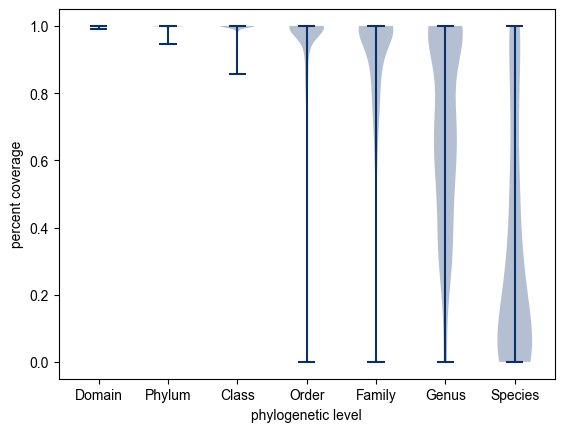

In [59]:
# I think the plot above might actually be better as a violin plot. 
fig, ax = plt.subplots()

ax.violinplot(coverage_by_habitat_df[LEVELS].values)

ax.set_xticks(np.arange(len(LEVELS)) + 1, labels=LEVELS)
ax.set_ylabel('percent coverage')
ax.set_xlabel('phylogenetic level')

plt.show()

Text(0, 0.5, 'percent coverage')

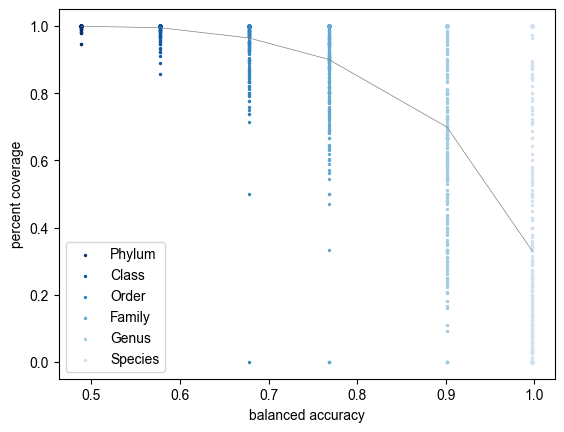

In [60]:
# Now make the plot showing baseline precision versus sample coverage. 
randrel_results = load_results_dict(os.path.join(PB_PATH, 'phylo_bias_results_randrel.json'))

fig, ax = plt.subplots()

x_vals = [randrel_results['scores'][level]['mean'] for level in LEVELS[1:]]
y_vals = [coverage_by_habitat_df[level].mean() for level in LEVELS[1:]]
ax.plot(x_vals, y_vals, linewidth=0.5, color='gray')


human_samples = coverage_by_habitat_df.habitat.str.contains('human').values # NOT a full match, so should pick up any habitat with substring "human."
colors = ['tab:blue' if not is_human else 'tab:red' for is_human in human_samples]

handles = []
for i, level in enumerate(LEVELS[1:]):
    handles.append(ax.scatter(np.array([x_vals[i]] * n), coverage_by_habitat_df[level].values, s=2))

ax.legend(handles, LEVELS[1:])

ax.set_xlabel('balanced accuracy')
ax.set_ylabel('percent coverage')


In [ ]:
# # Do we have any labels for any species from the training data?
# labels = dataset_load_all('KO', to_numpy=False)['labels'] # Feature type doesn't matter here, just loading labels. 

# species_overlap = set(labels.Species.values).intersection(set(taxonomy_df.Species.values))
# print('Overlapping species:', len(species_overlap))

In [ ]:
# # Load in the results of each training run. 
# nonlinear_results = dict() # Results of Nonlinear classifier. 
# logistic_results = dict() # Results of LogisticRegression-based classifier. 

# for feature_type in feature_types:
#     filename = f'run_results_nonlinear_{feature_type}.json'
#     nonlinear_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))
#     filename = f'run_results_logistic_{feature_type}.json'
#     logistic_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))

In [ ]:
# plot_model_accuracy_barplot(nonlinear_results)

In [ ]:
# plot_model_comparison_barplot(nonlinear_results, logistic_results)

In [ ]:
# plot_confusion_matrices(nonlinear_results)

In [ ]:
for feature_type in FEATURE_TYPES:
    # feature_type = 'aa_3mer'
    if feature_type != 'KO':
        model_class = 'nonlinear'
        phylo_bias_results = load_results_dict(os.path.join(RESULTS_PATH, f'phylo_bias_results_{model_class}_{feature_type}.json'))
        plot_phylo_bias(phylo_bias_results, feature_type=feature_type, show_points=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/prichter/Documents/aerobot/aerobot/../results/phylo_bias_results_nonlinear_embedding.genome.json'

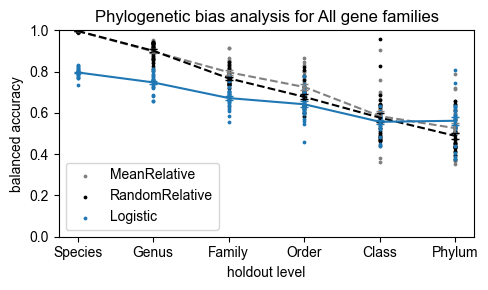

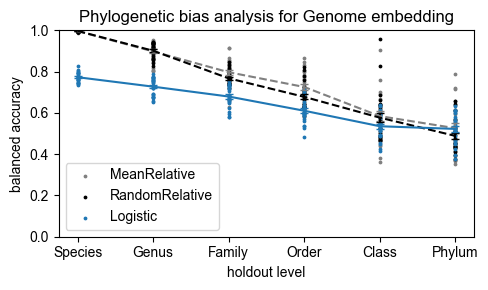

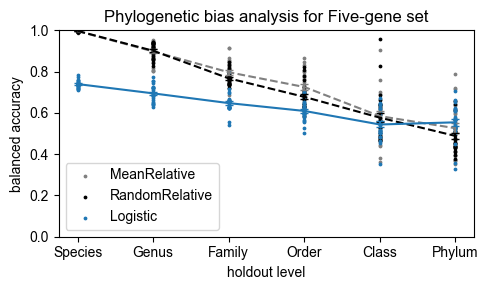

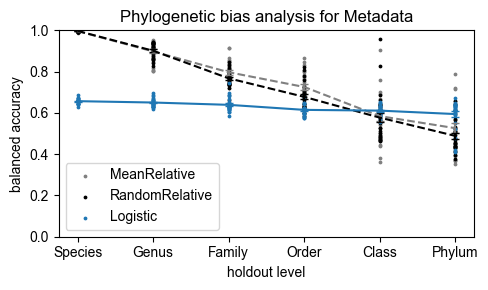

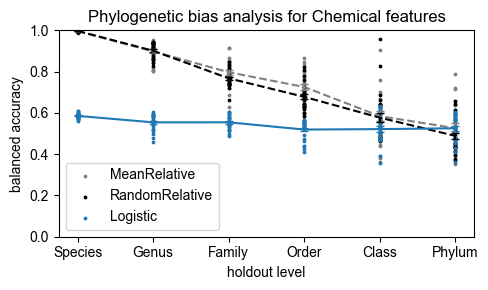

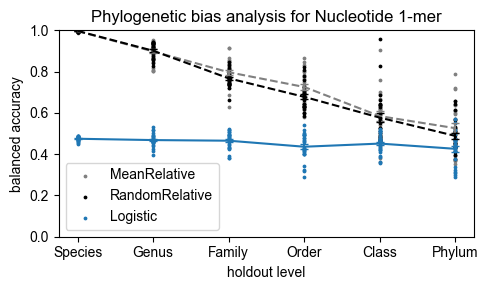

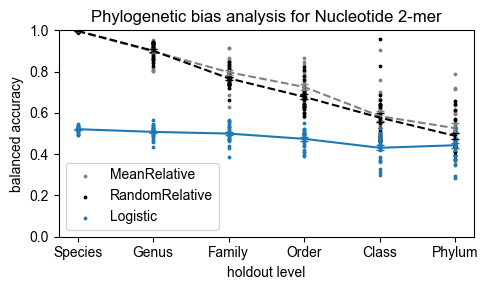

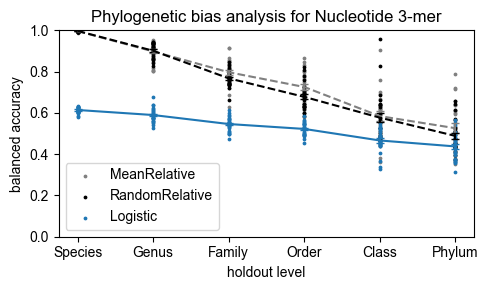

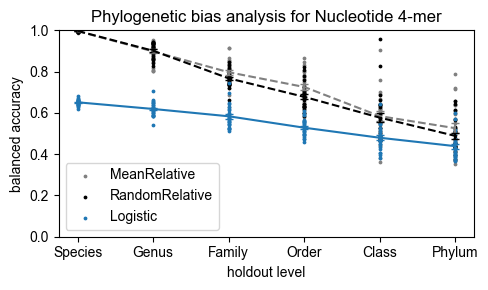

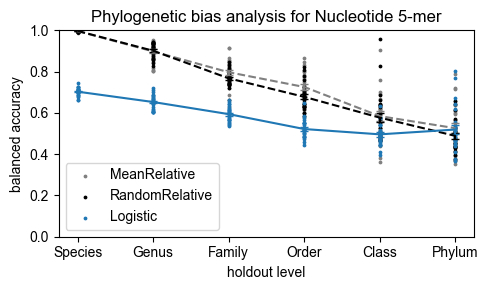

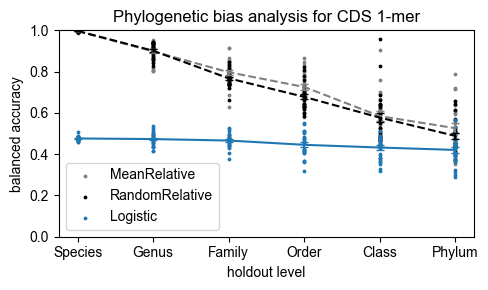

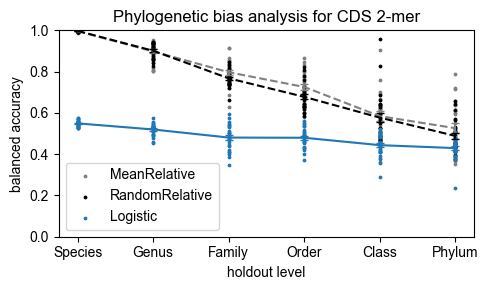

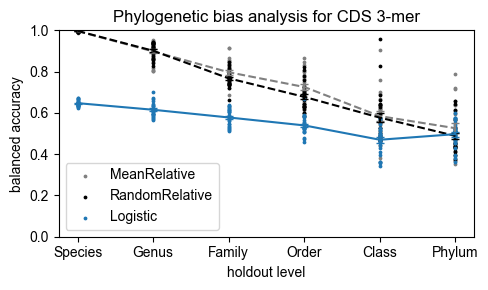

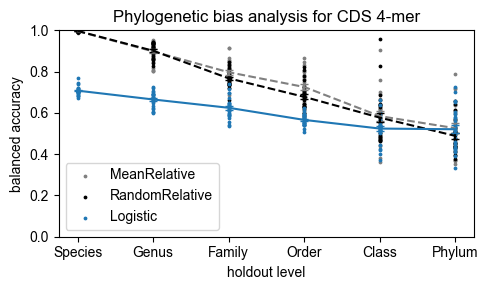

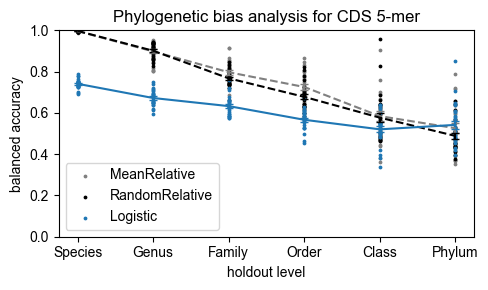

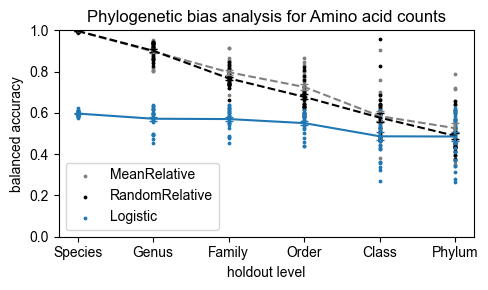

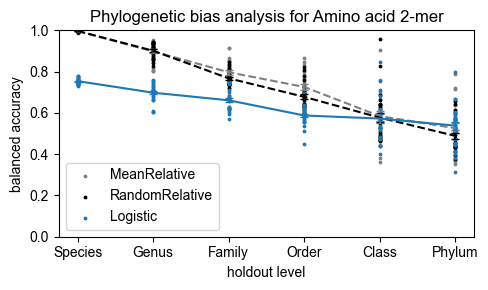

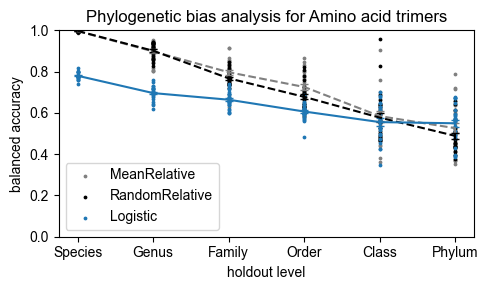

In [ ]:
for feature_type in FEATURE_TYPES:
    # feature_type = 'aa_3mer':
    model_class = 'logistic'
    phylo_bias_results = load_results_dict(os.path.join(RESULTS_PATH, f'phylo_bias_results_{model_class}_{feature_type}.json'))
    plot_phylo_bias(phylo_bias_results, feature_type=feature_type, show_points=True)